# Efficient Net B7

In [ ]:
# 🔹 System Utils
import hashlib
import zipfile
import random

# 🔹 Data Handling
import numpy as np
import pandas as pd

# 🔹 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 🔹 TensorFlow Core
import tensorflow as tf

# 🔹 Keras Applications
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.convnext import preprocess_input

# 🔹 Model Building
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# 🔹 Training Utils
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 🔹 Mlflow -> tracking
from utils.MLFlowTrackingConfig import MLFlowTracking

2025-04-22 10:52:09.477650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745319129.709919      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745319129.776263      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# load the dataset

data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/train_data.npz')

# input dataset
X = data['arr_0']

# output dataset
y = data['arr_1']

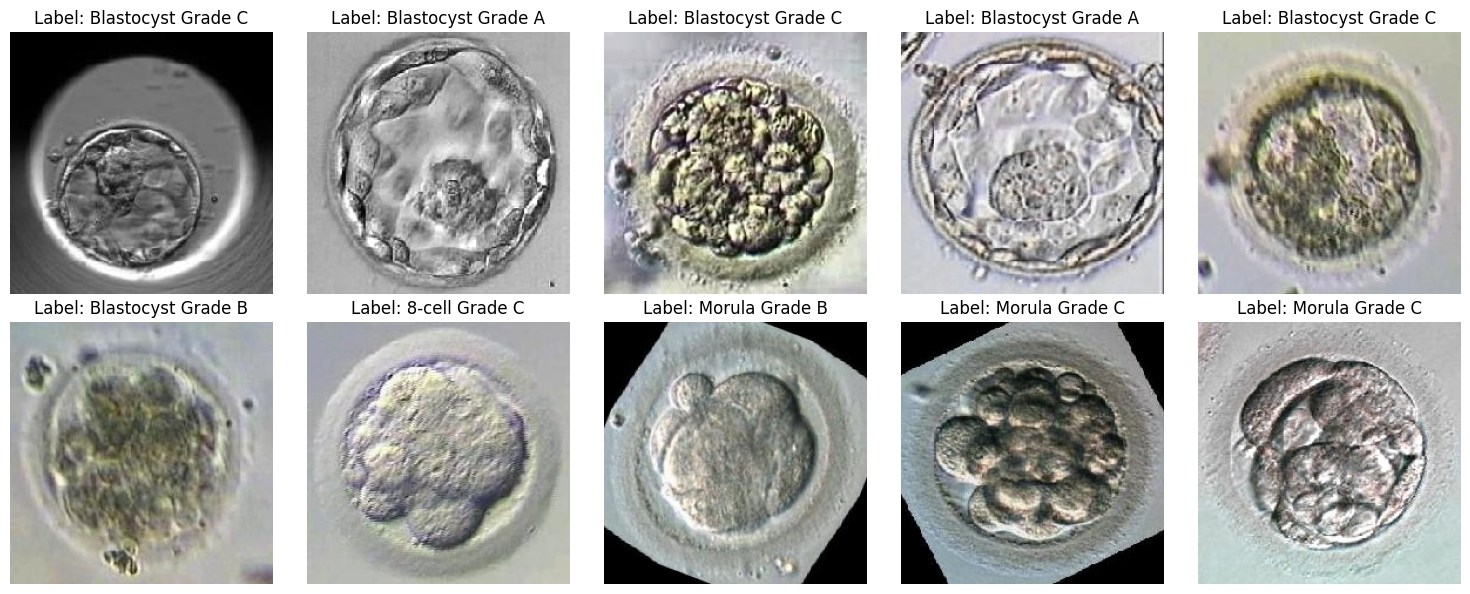

In [ ]:
# Visual the images in randomly random order 

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].astype('uint8'))
    plt.title(f"Label: {y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# shape

X.shape

(8621, 224, 224, 3)

In [11]:
# labels counts

pd.Series(y).value_counts()

Morula Grade C        900
Morula Grade B        900
Morula Grade A        900
Error Images          899
Blastocyst Grade C    893
Blastocyst Grade B    881
Blastocyst Grade A    876
8-cell Grade A        802
8-cell Grade C        796
8-cell Grade B        774
Name: count, dtype: int64

In [14]:
# now handel the labels

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

# matrix
labels = to_categorical(y_encoded, len(label_encoder.classes_))

In [15]:
# show the first five labels

labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [16]:
# train and test split 

x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size= 0.1, random_state=42, stratify = labels)

In [17]:
# check the shape -> train

x_train.shape, y_train.shape

((7758, 224, 224, 3), (7758, 10))

In [18]:
# check the shape -> test

x_test.shape, y_test.shape

((863, 224, 224, 3), (863, 10))

In [19]:
# Model

# image size
input_shape = (224, 224, 3)  

# base model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze base model
base_model.trainable = False

I0000 00:00:1745320646.855107      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745320646.855805      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [22]:
# 🔹 Custom head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs, x)

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 7, 7, 2560)          │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,787,489 (247.14 MB)

 Trainable params: 689,802 (2.63 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [24]:
# 🔹 Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# 🔹 Callbacks

# early stop
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

# reduce the learning rate
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [26]:
# 🔹 Train

history = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000,
          batch_size=32,
          callbacks=[early_stop, reduce_lr])

Epoch 1/1000


I0000 00:00:1745320802.479213     105 service.cc:148] XLA service 0x7b41b413de10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745320802.480015     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745320802.480046     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745320808.397614     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745320839.683427     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


243/243 ━━━━━━━━━━━━━━━━━━━━ 214s 515ms/step - accuracy: 0.4758 - loss: 1.3248 - val_accuracy: 0.6547 - val_loss: 0.8781 - learning_rate: 0.0010
Epoch 2/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 69s 286ms/step - accuracy: 0.6899 - loss: 0.7623 - val_accuracy: 0.7196 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 3/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 280ms/step - accuracy: 0.7516 - loss: 0.6261 - val_accuracy: 0.7590 - val_loss: 0.6141 - learning_rate: 0.0010
Epoch 4/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 281ms/step - accuracy: 0.7894 - loss: 0.5311 - val_accuracy: 0.7752 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 5/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 281ms/step - accuracy: 0.8209 - loss: 0.4503 - val_accuracy: 0.8413 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 6/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 280ms/step - accuracy: 0.8563 - loss: 0.3810 - val_accuracy: 0.8158 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 7/1000
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 282ms/step - accuracy: 0

In [ ]:
# save the model 

model.save("EfficientNetB7.h5")

**Train and Validation Loss Plot**


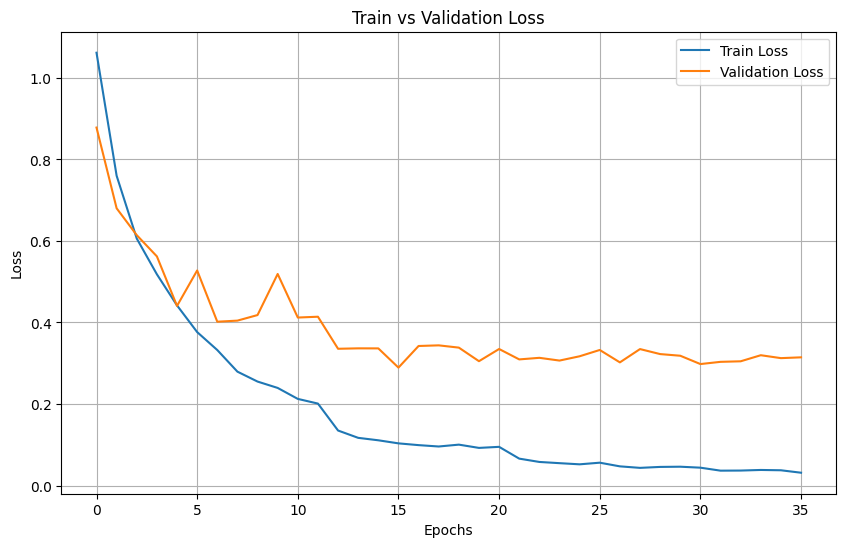

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Train and Validation Accuracy Plot**

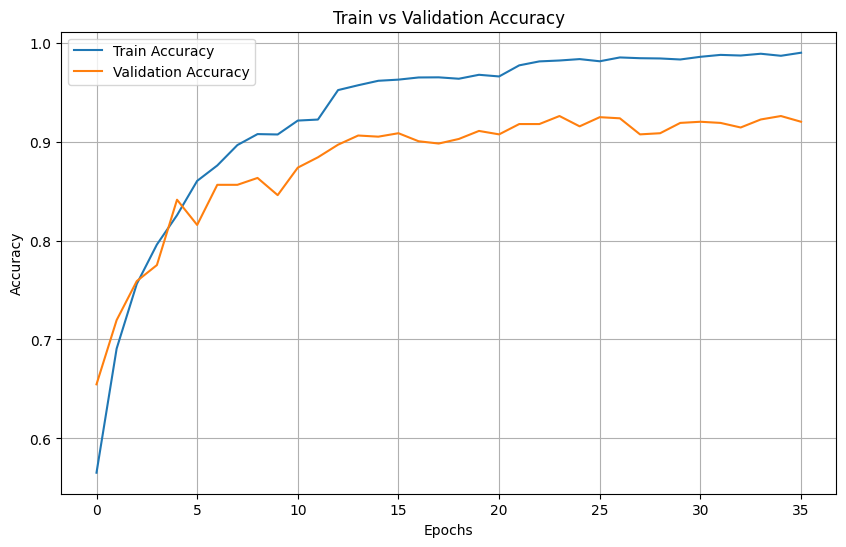

In [29]:
train_acc = history.history['accuracy']  
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation 

### Test data

In [30]:
test_data = np.load('/kaggle/working/test_data.npz')

X_test = test_data['arr_0']

y_test = test_data['arr_1']

In [31]:
labelEncodeY = LabelEncoder()

y_test = labelEncodeY.fit_transform(y_test)

y_test = to_categorical(y_test, len(labelEncodeY.classes_))

y_test = np.array(y_test)

In [32]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1, batch_size = 16)

print(f"🧪 Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"📉 Test Loss: {test_loss:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 223ms/step - accuracy: 0.9240 - loss: 0.1998
🧪 Test Accuracy: 93.01%
📉 Test Loss: 0.2102


### Train data

In [33]:
train_data = np.load('/kaggle/working/train_data.npz')

X_train = train_data['arr_0']

y_train = train_data['arr_1']

In [34]:
labelEncodeY = LabelEncoder()

y_train = labelEncodeY.fit_transform(y_train)

y_train = to_categorical(y_train, len(labelEncodeY.classes_))

y_train = np.array(y_train)

In [35]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1, batch_size = 8)

print(f"🧪 Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"📉 Train Loss: {train_loss:.4f}")

1078/1078 ━━━━━━━━━━━━━━━━━━━━ 90s 76ms/step - accuracy: 0.9797 - loss: 0.0684
🧪 Train Accuracy: 97.84%
📉 Train Loss: 0.0689


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [4]:
MLFlowTracking(model, 224, 3, 32, False, 1000, 10, 'imagenet', 6.2500e-05, 0.0293,  0.9797, 0.9240, 'EfficientNetB7')

Accessing as revanth-kumar-01-ai

Initialized MLflow to track repo "revanth-kumar-01-ai/360DigitMG-Training-Phase"

Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!

2025/04/22 17:57:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/22 17:58:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'EfficientNetB7'.
2025/04/22 17:59:50 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: EfficientNetB7, version 1
Created version '1' of model 'EfficientNetB7'.


🏃 View run beautiful-slug-158 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/a48e49221efd4f63a806732cbda9f7af
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
